
Introductory Notebook


Epoch 5, Loss: 1.0668
Epoch 10, Loss: 0.8230
Epoch 15, Loss: 0.5884
Epoch 20, Loss: 0.3760
Epoch 25, Loss: 0.2002
Epoch 30, Loss: 0.0892
Node embeddings:
 tensor([[ 3.4825,  0.1975, -1.9598],
        [ 0.5391,  2.3393, -1.9012],
        [ 2.1324, -0.7696, -2.8908],
        [-0.1053,  3.7806, -1.9735],
        [ 2.3289, -0.4895, -1.2122]])


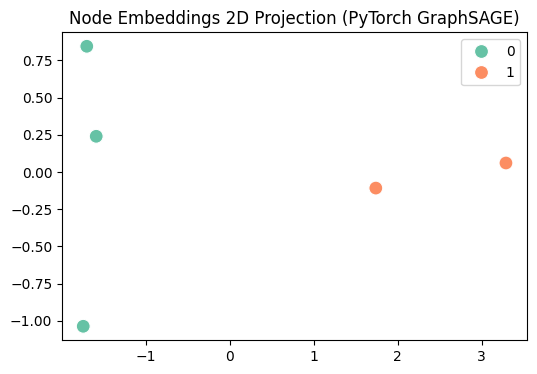

In [1]:
# ===============================
# Milestone 1 Introductory Notebook
# GraphSAGE in pure PyTorch (Python 3.10)
# ===============================

import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Step 1: Create sample graph
# -------------------------------
edges = [(0,1),(0,2),(1,2),(2,3),(3,4)]
G_nx = nx.DiGraph()
G_nx.add_edges_from(edges)

# Node features
num_nodes = G_nx.number_of_nodes()
feature_dim = 5
node_features = pd.DataFrame(np.random.rand(num_nodes, feature_dim),
                             index=range(num_nodes),
                             columns=[f"feat_{i}" for i in range(feature_dim)])

# Standardize features
scaler = StandardScaler()
node_features_scaled = pd.DataFrame(scaler.fit_transform(node_features), columns=node_features.columns)

# -------------------------------
# Step 2: Prepare adjacency matrix
# -------------------------------
adj_matrix = nx.to_numpy_array(G_nx)
adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
features = torch.tensor(node_features_scaled.values, dtype=torch.float32)

# -------------------------------
# Step 3: Define simple GraphSAGE layer
# -------------------------------
class GraphSAGELayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super().__init__()
        self.linear = nn.Linear(in_feats*2, out_feats)
    
    def forward(self, x, adj):
        h = torch.matmul(adj, x)  # aggregate neighbor features
        h = torch.cat([x, h], dim=1)  # concatenate with self
        return self.linear(h)

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super().__init__()
        self.layer1 = GraphSAGELayer(in_feats, hidden_feats)
        self.layer2 = GraphSAGELayer(hidden_feats, out_feats)
    
    def forward(self, x, adj):
        h = F.relu(self.layer1(x, adj))
        h = self.layer2(h, adj)
        return h

# -------------------------------
# Step 4: Train model
# -------------------------------
in_feats = feature_dim
hidden_feats = 8
out_feats = 3  # example: 3 classes
model = GraphSAGE(in_feats, hidden_feats, out_feats)

labels = torch.tensor([0,1,0,1,0])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(30):
    optimizer.zero_grad()
    logits = model(features, adj_matrix)
    loss = loss_fn(logits, labels)
    loss.backward()
    optimizer.step()
    if (epoch+1)%5==0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# -------------------------------
# Step 5: Node embeddings
# -------------------------------
model.eval()
with torch.no_grad():
    embeddings = model(features, adj_matrix)
    print("Node embeddings:\n", embeddings)

# -------------------------------
# Step 6: 2D PCA visualization
# -------------------------------
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings.numpy())

plt.figure(figsize=(6,4))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=labels.numpy(), palette='Set2', s=100)
plt.title("Node Embeddings 2D Projection (PyTorch GraphSAGE)")
plt.show()
